# <center> Swarm optimization Project : Bacterial Foraging   

BFO or bacterial foraging optimization is an optimization algorithm inspired by the behaviour of E.coli bacteria when searching for food and nutriments. The concept revolve on using a swarm behaviour  to find the nutriments <i>( local / global minima of an objective function )</i> while minimizing the energy consumption. In this preject, we will delve deeper into the algorithm and its efficiency compared to other solutions <i>( Stochastic gradient descent for example ) </i> 

## Importing our toolbox

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import time
from sklearn.metrics import f1_score, recall_score, make_scorer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import movie_reviews


In the first part of this notebook, we will be comparing the performance of the BFO and SGD onsome benchmark functions. Next, we will use the BFO algorithm to optmize the C regularization parameter of the logistic regression used on a sentiment Analysis task. Happy reading :)

### Benchmark functions

In [2]:
#Defining some benchmark function

def ackley_function(position):
    a = 20
    b = 0.2
    c = 2 * np.pi
    d = len(position)
    sum1 = np.sum(position**2)
    sum2 = np.sum(np.cos(c * position))
    term1 = -a * np.exp(-b * np.sqrt(sum1 / d))
    term2 = -np.exp(sum2 / d)
    return term1 + term2 + a + np.exp(1)


def square_sum(x):
    return np.sum(x**2)

def rastrigin_function(x):
    n = len(x)
    A = 10
    return A * n + np.sum(x**2 - A * np.cos(2 * np.pi * x)) 

## Implementing BFO 

In [3]:
class BFO:
    def __init__(self, p, S, Nc, Ns, Ned, Nr, ped, LB, UB, C, OF):
        self.p = p            # Number of dimensions
        self.S = S            # Number of bacteria
        self.Nc = Nc          # Number of chemotactic steps
        self.Ns = Ns          # Swimming length
        self.Ned = Ned        # Number of elimination-dispersal events
        self.Nr = Nr          # Number of reproduction steps
        self.ped = ped        # Elimination-dispersal probability
        self.LB = np.array(LB) # Lower bounds
        self.UB = np.array(UB) # Upper bounds
        self.C = C            # Step size
        self.OF = OF          # Objective function

    def run(self):
        # Initialize population of bacteria
        population = self.LB[:, np.newaxis] + (self.UB[:, np.newaxis] - self.LB[:, np.newaxis]) * np.random.rand(self.p, self.S)
        fitness = np.apply_along_axis(self.OF, 0, population)
        best_solution = population[:, np.argmin(fitness)]
        best_fitness = np.min(fitness)
        best_fitness_history = [best_fitness]

        # Elimination-dispersal loop
        for l in range(self.Ned):
            # Reproduction loop
            for k in range(self.Nr):
                # Chemotactic loop
                for j in range(self.Nc):
                    for i in range(self.S):
                        # Perform a chemotactic step
                        delta = (2 * np.random.rand(self.p) - 1)
                        delta /= np.linalg.norm(delta)
                        new_position = population[:, i] + self.C * delta
                        
                        # Ensure the new position is within bounds
                        new_position = np.clip(new_position, self.LB, self.UB)
                        new_fitness = self.OF(new_position)

                        # Swim
                        for m in range(self.Ns):
                            if new_fitness < fitness[i]:
                                population[:, i] = new_position
                                fitness[i] = new_fitness

                                new_position = population[:, i] + self.C * delta
                                new_position = np.clip(new_position, self.LB, self.UB)
                                new_fitness = self.OF(new_position)
                                best_fitness_history.append(new_fitness)
                            else:
                                break

                # Reproduction
                health = np.sum(fitness.reshape(self.S, 1), axis=1)
                sorted_indices = np.argsort(health)
                population = population[:, sorted_indices]
                fitness = fitness[sorted_indices]

                # Split the best bacteria
                for i in range(self.S // 2, self.S):
                    population[:, i] = population[:, i - self.S // 2]
                    fitness[i] = fitness[i - self.S // 2]

            # Elimination-dispersal
            for i in range(self.S):
                if np.random.rand() < self.ped:
                    population[:, i] = self.LB + (self.UB - self.LB) * np.random.rand(self.p)
                    fitness[i] = self.OF(population[:, i])
                    best_fitness_history.append(new_fitness)
                    
            # Update best solution
            current_best_fitness = np.min(fitness)
            if current_best_fitness < best_fitness:
                best_fitness = current_best_fitness
                best_solution = population[:, np.argmin(fitness)]
                best_fitness_history.append(new_fitness)

        return best_fitness, best_solution, best_fitness_history


## Adaptive BFO 

In [38]:
import numpy as np

class ABFO0:
    def __init__(self, p, S, Nc, Ns, Ned, Nr, ped, LB, UB, C_initial, alpha, beta, epsilon, OF):
        self.p = p            # Number of dimensions
        self.S = S            # Number of bacteria
        self.Nc = Nc          # Number of chemotactic steps
        self.Ns = Ns          # Swimming length
        self.Ned = Ned        # Number of elimination-dispersal events
        self.Nr = Nr          # Number of reproduction steps
        self.ped = ped        # Elimination-dispersal probability
        self.LB = np.array([LB] * p) # Lower bounds
        self.UB = np.array([UB] * p) # Upper bounds
        self.C_initial = C_initial  # Initial step size
        self.alpha = alpha    # Parameter adaptation factor
        self.beta = beta      # Parameter adaptation factor
        self.epsilon = epsilon # Convergence threshold
        self.OF = OF          # Objective function

    def adapt_parameters(self, fitness, best_fitness):
        if best_fitness < self.epsilon:
            return self.C_initial / self.alpha, self.epsilon / self.beta
        return self.C_initial, self.epsilon

    def run(self):
        # Initialize population of bacteria
        population = self.LB[:, np.newaxis] + (self.UB[:, np.newaxis] - self.LB[:, np.newaxis]) * np.random.rand(self.p, self.S)
        fitness = np.apply_along_axis(self.OF, 0, population)
        best_solution = population[:, np.argmin(fitness)]
        best_fitness = np.min(fitness)
        best_fitness_history = [best_fitness]

        C = self.C_initial  # Initialize C

        # Elimination-dispersal loop
        for l in range(self.Ned):
            # Reproduction loop
            for k in range(self.Nr):
                # Chemotactic loop
                for j in range(self.Nc):
                    for i in range(self.S):
                        # Perform a chemotactic step
                        delta = (2 * np.random.rand(self.p) - 1)
                        delta /= np.linalg.norm(delta)
                        new_position = population[:, i] + C * delta
                        
                        # Ensure the new position is within bounds
                        new_position = np.clip(new_position, self.LB, self.UB)
                        new_fitness = self.OF(new_position)

                        # Swim
                        for m in range(self.Ns):
                            if new_fitness < fitness[i]:
                                population[:, i] = new_position
                                fitness[i] = new_fitness

                                new_position = population[:, i] + C * delta
                                new_position = np.clip(new_position, self.LB, self.UB)
                                new_fitness = self.OF(new_position)
                            else:
                                break

                    best_fitness_history.append(np.min(fitness))
                    
                # Reproduction
                health = np.sum(fitness.reshape(self.S, 1), axis=1)
                sorted_indices = np.argsort(health)
                population = population[:, sorted_indices]
                fitness = fitness[sorted_indices]

                # Split the best bacteria
                for i in range(self.S // 2, self.S):
                    population[:, i] = population[:, i - self.S // 2]
                    fitness[i] = fitness[i - self.S // 2]

            # Elimination-dispersal
            for i in range(self.S):
                if np.random.rand() < self.ped:
                    population[:, i] = self.LB + (self.UB - self.LB) * np.random.rand(self.p)
                    fitness[i] = self.OF(population[:, i])
                    
            # Update best solution and adapt parameters
            current_best_fitness = np.min(fitness)
            if current_best_fitness < best_fitness:
                best_fitness = current_best_fitness
                best_solution = population[:, np.argmin(fitness)]

            C, self.epsilon = self.adapt_parameters(fitness, best_fitness)
            best_fitness_history.append(best_fitness)

        return best_fitness, best_solution, best_fitness_history

# Example objective function
def sphere_function(x):
    return np.sum(x**2)

# Parameters
population_size = 50
dimension = 30
lower_bound = -5.12
upper_bound = 5.12
C_initial = 0.05
alpha = 0.95
beta = 0.9
epsilon = 1e-6
Nc = 10
Ns = 4
Ned = 2
Nr = 4
ped = 0.25

# Initialize and run ABFO0
abfo0 = ABFO0(dimension, population_size, Nc, Ns, Ned, Nr, ped, lower_bound, upper_bound, C_initial, alpha, beta, epsilon, sphere_function)
best_fitness, best_solution, history = abfo0.run()

print("Best solution found:", best_solution)
print("Best fitness found:", best_fitness)
print('Best fitness history:', history)


Best solution found: [-0.27624083  2.90001677 -4.0664531  -2.72875312  3.74798045 -1.90746636
 -2.75723757  1.58224769  0.83060058 -0.70914556  4.51276855  2.31985647
 -1.3749302  -2.63124155 -3.27951141 -0.04674269 -1.48280476  0.94269921
  0.33931713  1.35763187 -1.38591314 -3.70839608  4.2039817  -0.76467699
 -2.8937474  -2.7375036   0.27779556 -0.95503631 -0.33657449  1.79288291]
Best fitness found: 165.93255497062228
Best fitness history: [201.81156344909414, 201.81156344909414, 200.28519882688653, 199.7131455490478, 198.78225209164953, 198.78225209164953, 198.78225209164953, 198.78225209164953, 198.78225209164953, 198.78225209164953, 198.78225209164953, 196.7702299190122, 196.7504260826876, 196.7504260826876, 196.74887555492572, 196.74887555492572, 196.74887555492572, 196.25023793666068, 195.62572363638054, 195.52005394855118, 195.24086465246162, 194.39689912803465, 194.39689912803465, 194.36435816762196, 193.71275378761726, 193.66199719624316, 192.76075036209028, 192.75227554636

In [29]:
abfo0 = ABFO0(ackley_function, population_size, dimension, lower_bound, upper_bound, C_initial, alpha, beta, n, max_generations, elimination_dispersal_prob, num_elimination_dispersal_events, d_attract, w_attract, h_repellent, w_repellent)
best_solution, best_fitness, _ = abfo0.optimize()


print("Best solution found:", best_solution)
print("Best fitness found:", best_fitness)

Best solution found: [-2.96255395e+00 -3.93117735e+00 -9.93140320e-01  2.97874671e+00
 -9.96961878e-01  5.64918235e-03  9.87137250e-01  2.98501563e+00
  1.81674538e-04  3.95916484e+00  9.83393252e-01 -1.98318438e+00
  6.03640130e-03 -1.97540045e+00  1.98669567e+00  1.98275209e+00
  3.97177702e+00  1.00240187e+00  1.95139812e+00  2.97241201e+00
  2.95915320e+00 -4.95664959e+00 -2.00146420e+00  1.97868015e+00
 -3.95665967e+00  1.99670001e+00  1.98489994e+00  9.93345489e-01
 -9.76923229e-03  1.97980184e+00]
Best fitness found: 7.724171657399909


In [20]:
def sgd(function, gradient_function, dim, lr=0.01, epochs=1000):
    position = np.random.uniform(-5, 5, dim)
    best_fitness_history = []
    for epoch in range(epochs):
        grad = gradient_function(position)
        position -= lr * grad
        value = function(position)
        best_fitness_history.append(value)
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Position: {position}, Value: {value}')
    return position, best_fitness_history

# Test the functions
dim = 10
learning_rate = 0.01
epochs = 1000



In [31]:
# Parameters
dim = 10          
S = 10         
Nc = 20
Ns = 7
Ned = 5
Nr = 10
def gradient_ackley_function(position):
    a = 20
    b = 0.2
    c = 2 * np.pi
    d = len(position)
    sum1 = np.sum(position**2)
    sum2 = np.sum(np.cos(c * position))

    grad = np.zeros_like(position)
    for i in range(d):
        grad[i] = position[i] * (a * b / np.sqrt(sum1 / d) * np.exp(-b * np.sqrt(sum1 / d))) + c * np.sin(c * position[i]) * np.exp(sum2 / d) / d
    return grad

def gradient_square_sum(x):
    return 2 * x

def gradient_rastrigin_function(x):
    n = len(x)
    A = 10
    grad = 2 * x + 2 * np.pi * A * np.sin(2 * np.pi * x)
    return grad
ped = 0.25
LB = [-5] * dim
UB = [5] * dim
C = 1
learning_rate = 0.01
epochs = 1000

# BFO on Ackley function
bfo_ackley = BFO(dim, S, Nc, Ns, Ned, Nr, ped, LB, UB, C, ackley_function)
best_fit_ackley, best_sol_ackley, history_bfo_ackley = bfo_ackley.run()
print("BFO - Ackley Function:")
print("Best fitness:", best_fit_ackley)
print("Best solution:", best_sol_ackley)

# SGD on Ackley function
best_sol_sgd_ackley, history_sgd_ackley = sgd(ackley_function, gradient_ackley_function, dim, learning_rate, epochs)


abfo0 = ABFO0(ackley_function, S, dim, lower_bound, upper_bound, C_initial, alpha, beta, n, max_generations, ped, num_elimination_dispersal_events, d_attract, w_attract, h_repellent, w_repellent)
best_solution_abfo0, best_fitness_abfo0, history_abfo0_ackley = abfo0.optimize()


print("Best solution found:", best_solution_abfo0)
print("Best fitness found:", best_fitness_abfo0)


BFO - Ackley Function:
Best fitness: 1.796185638925604
Best solution: [-0.02515776  0.10702474  0.28591268  0.36134006  0.22644257  0.00512543
  0.09990577  0.07827772  0.2113869  -0.02606303]
Epoch 0, Position: [-3.20435585  4.39882797  4.95576865  4.07251047  2.43230646 -4.91894314
  3.45261614  1.98087783 -0.96983084  0.69567577], Value: 11.441584294046207
Epoch 100, Position: [-0.9476236   1.30708101  1.48321311  1.2328706   0.72852418 -1.47348888
  0.99057947  0.68888889 -0.5008148   0.45882832], Value: 5.735124159901382
Epoch 200, Position: [-0.0192831   0.02690763  0.0308325   0.02539184  0.01305515 -0.03059822
  0.02030371  0.0117927  -0.00640692  0.00548153], Value: 0.10748294452292173
Epoch 300, Position: [-0.01970607  0.02684783  0.03031196  0.02546965  0.01353258 -0.03010953
  0.02069096  0.01225152 -0.00670366  0.00574002], Value: 0.10751584677318293
Epoch 400, Position: [-0.02008661  0.0267567   0.02982057  0.0255053   0.01399445 -0.02964483
  0.02103259  0.01269965 -0.00

In [34]:
# BFO on Square Sum function
bfo_square_sum = BFO(dim, S, Nc, Ns, Ned, Nr, ped, LB, UB, C, square_sum)
best_fit_square_sum, best_sol_square_sum, history_bfo_square_sum = bfo_square_sum.run()
print("BFO - Square Sum Function:")
print("Best fitness:", best_fit_square_sum)
print("Best solution:", best_sol_square_sum)

# SGD on Square Sum function
best_sol_sgd_square_sum, history_sgd_square_sum = sgd(square_sum, gradient_square_sum, dim, learning_rate, epochs)

abfo0_square_sum = ABFO0(square_sum, S, dim, LB, UB, C_initial, alpha, beta, n, max_generations, ped, num_elimination_dispersal_events, d_attract, w_attract, h_repellent, w_repellent)
best_sol_abfo0_square_sum, best_fit_abfo0_square_sum, history_abfo0_ackley_square_sum = abfo0_square_sum.optimize()


print("Best solution found:", best_sol_abfo0_square_sum)
print("Best fitness found:", best_fit_abfo0_square_sum)



BFO - Square Sum Function:
Best fitness: 0.23697201601068657
Best solution: [ 0.18302507  0.03669449  0.21166276 -0.03107055  0.01252737 -0.25268002
  0.14775173 -0.1395429  -0.02797556  0.22421261]
Epoch 0, Position: [-2.99056279 -2.62404134  1.74529499  4.51559603 -0.44073792  3.46150557
 -1.59181743 -4.34235608 -2.74769416 -4.61650029], Value: 101.69382888841275
Epoch 100, Position: [-0.39660711 -0.3479992   0.23146025  0.59885634 -0.05845047  0.45906333
 -0.21110612 -0.57588133 -0.36439798 -0.61223822], Value: 1.7885856326207898
Epoch 200, Position: [-0.05259786 -0.0461515   0.03069616  0.07942006 -0.00775167  0.06088078
 -0.0279968  -0.07637313 -0.0483263  -0.08119476], Value: 0.031457548606295196
Epoch 300, Position: [-0.0069755  -0.00612059  0.00407091  0.01053265 -0.00102802  0.00807398
 -0.00371292 -0.01012857 -0.00640901 -0.01076801], Value: 0.0005532736852344108
Epoch 400, Position: [-0.00092509 -0.00081171  0.00053988  0.00139684 -0.00013634  0.00107077
 -0.00049241 -0.0013

In [27]:
# BFO on Rastrigin function
bfo_rastrigin = BFO(dim, S, Nc, Ns, Ned, Nr, ped, LB, UB, C, rastrigin_function)
best_fit_rastrigin, best_sol_rastrigin, history_bfo_rastrigin = bfo_rastrigin.run()
print("BFO - Rastrigin Function:")
print("Best fitness:", best_fit_rastrigin)
print("Best solution:", best_sol_rastrigin)

# SGD on Rastrigin function
best_sol_sgd_rastrigin, history_sgd_rastrigin = sgd(rastrigin_function, gradient_rastrigin_function, dim, learning_rate, epochs)


BFO - Rastrigin Function:
Best fitness: 55.72570776157206
Best solution: [-0.93070526  1.02046499  0.98311367  1.01947122 -0.09402793  1.42054777
  3.29667962 -0.93027708 -0.06827822  1.05415647]
Epoch 0, Position: [-2.61020157 -1.80381025  0.77017367 -3.67562142 -3.55945509 -3.43150842
  0.38452798 -1.24322894 -3.29082439 -4.9494824 ], Value: 211.7478796488349
Epoch 100, Position: [-3.17096051 -1.75235776  0.61540587 -3.26241573 -3.17430748 -3.15045143
 -0.01031813 -1.36876829 -2.65078113 -3.65634539], Value: 167.5345092867306
Epoch 200, Position: [-2.71828902 -1.7846524   1.28939282 -3.32908449 -3.30590135 -3.18636785
  0.03781131 -0.88590507 -3.23520817 -2.66345082], Value: 156.32064360629178
Epoch 300, Position: [-2.6033753  -1.81511992  1.27811794 -2.72982457 -2.63950937 -2.53836685
 -0.24225174 -1.2916502  -3.09620171 -3.32441069], Value: 176.42849008109434
Epoch 400, Position: [-2.98170939 -1.81877972  1.08220588 -3.1601658  -2.53999957 -3.3159711
  0.0542198  -0.5774139  -2.932

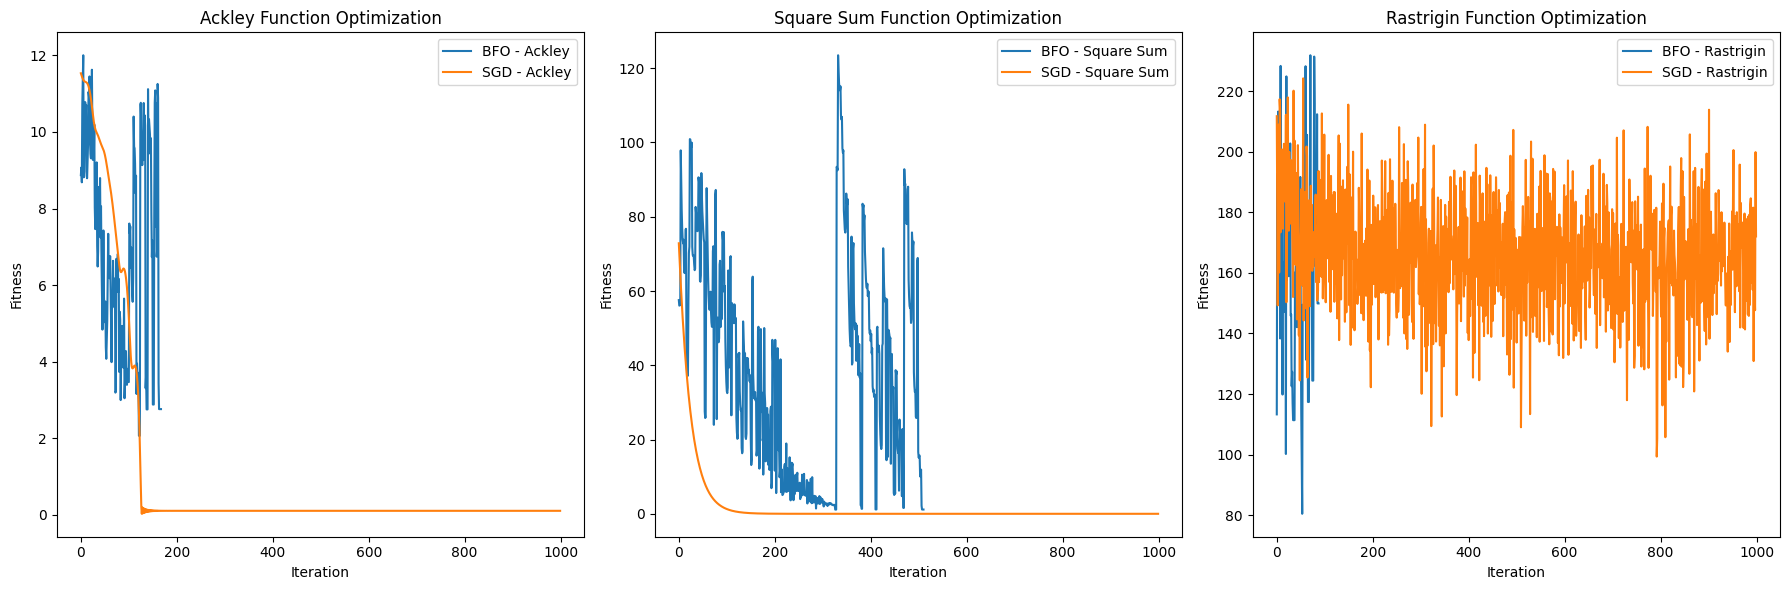

In [28]:
# Plotting the results
plt.figure(figsize=(18, 6))

# Ackley function
plt.subplot(1, 3, 1)
plt.plot(history_bfo_ackley, label='BFO - Ackley')
plt.plot(history_sgd_ackley, label='SGD - Ackley')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.legend()
plt.title('Ackley Function Optimization')

# Square Sum function
plt.subplot(1, 3, 2)
plt.plot(history_bfo_square_sum, label='BFO - Square Sum')
plt.plot(history_sgd_square_sum, label='SGD - Square Sum')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.legend()
plt.title('Square Sum Function Optimization')

# Rastrigin function
plt.subplot(1, 3, 3)
plt.plot(history_bfo_rastrigin, label='BFO - Rastrigin')
plt.plot(history_sgd_rastrigin, label='SGD - Rastrigin')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.legend()
plt.title('Rastrigin Function Optimization')

plt.tight_layout()
plt.show()

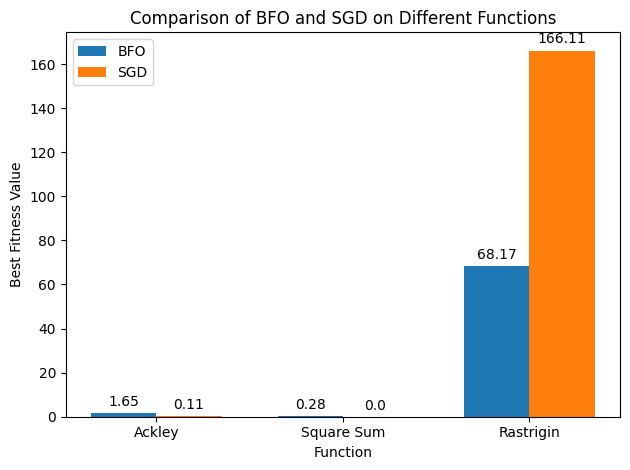

In [17]:
# Bar plot to compare final best fitness values
functions = ['Ackley', 'Square Sum', 'Rastrigin']
bfo_results = [best_fit_ackley, best_fit_square_sum, best_fit_rastrigin]
sgd_results = [history_sgd_ackley[-1], history_sgd_square_sum[-1], history_sgd_rastrigin[-1]]

x = np.arange(len(functions))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, bfo_results, width, label='BFO')
rects2 = ax.bar(x + width/2, sgd_results, width, label='SGD')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Function')
ax.set_ylabel('Best Fitness Value')
ax.set_title('Comparison of BFO and SGD on Different Functions')
ax.set_xticks(x)
ax.set_xticklabels(functions)
ax.legend()

# Function to add value labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

## Sentiment Analysis optimization using BFO 

This part is about optimizing the sentiment analysis task done by the logistic regerssion using the BFO algorithm. We will be using the movie_reviews dataset present on nltk library, containing reviews labeled between positive and negative.

In [12]:
import nltk
nltk.download('movie_reviews')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


True

### Preparing the data

In [30]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from nltk.corpus import movie_reviews

# Load movie reviews dataset from NLTK
movie_reviews_data = [(movie_reviews.raw(fileid), category) for category in movie_reviews.categories() for fileid in movie_reviews.fileids(category)]

# Prepare data
X, y = zip(*movie_reviews_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize text data
vectorizer = CountVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

### Defining the objective function and the BFO algorithm

In [15]:


# Define objective function for BFO
def objective_function(params):
    C = params[0]
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    return accuracy_score(y_test, y_pred)

# BFO parameters
p = 1  # Number of dimensions (C parameter)
S = 10  # Number of bacteria
Nc = 10  # Number of chemotactic steps
Ns = 5  # Swimming length
Ned = 2  # Number of elimination-dispersal events
Nr = 5  # Number of reproduction steps
ped = 0.1  # Elimination-dispersal probability
LB = [0.1]  # Lower bound for C parameter
UB = [1.0]  # Upper bound for C parameter
C = 0.1  # Step size

class BFO:
    def __init__(self, p, S, Nc, Ns, Ned, Nr, ped, LB, UB, C, OF):
        self.p = p
        self.S = S
        self.Nc = Nc
        self.Ns = Ns
        self.Ned = Ned
        self.Nr = Nr
        self.ped = ped
        self.LB = np.array(LB)
        self.UB = np.array(UB)
        self.C = C
        self.OF = OF

    def run(self):
        # Initialize population of bacteria
        population = self.LB[:, np.newaxis] + (self.UB[:, np.newaxis] - self.LB[:, np.newaxis]) * np.random.rand(self.p, self.S)
        fitness = np.apply_along_axis(self.OF, 0, population)
        best_solution = population[:, np.argmax(fitness)]
        best_fitness = np.max(fitness)

        # Elimination-dispersal loop
        for l in range(self.Ned):
            # Reproduction loop
            for k in range(self.Nr):
                # Chemotactic loop
                for j in range(self.Nc):
                    for i in range(self.S):
                        # Perform a chemotactic step
                        delta = (2 * np.random.rand(self.p) - 1)
                        delta /= np.linalg.norm(delta)
                        new_position = population[:, i] + self.C * delta
                        
                        # Ensure the new position is within bounds
                        new_position = np.clip(new_position, self.LB, self.UB)
                        new_fitness = self.OF(new_position)

                        # Swim
                        for m in range(self.Ns):
                            if new_fitness > fitness[i]:
                                population[:, i] = new_position
                                fitness[i] = new_fitness

                                new_position = population[:, i] + self.C * delta
                                new_position = np.clip(new_position, self.LB, self.UB)
                                new_fitness = self.OF(new_position)
                            else:
                                break

                # Reproduction
                health = np.sum(fitness.reshape(self.S, 1), axis=1)
                sorted_indices = np.argsort(health)
                population = population[:, sorted_indices]
                fitness = fitness[sorted_indices]

                # Split the best bacteria
                for i in range(self.S // 2, self.S):
                    population[:, i] = population[:, i - self.S // 2]
                    fitness[i] = fitness[i - self.S // 2]

            # Elimination-dispersal
            for i in range(self.S):
                if np.random.rand() < self.ped:
                    population[:, i] = self.LB + (self.UB - self.LB) * np.random.rand(self.p)
                    fitness[i] = self.OF(population[:, i])

            # Update best solution
            current_best_fitness = np.max(fitness)
            if current_best_fitness > best_fitness:
                best_fitness = current_best_fitness
                best_solution = population[:, np.argmax(fitness)]

        return best_fitness, best_solution

# Create a BFO instance
bfo = BFO(p, S, Nc, Ns, Ned, Nr, ped, LB, UB, C, objective_function)

# Run BFO
best_fit_bfo, best_sol_bfo = bfo.run()

print("Best accuracy achieved by BFO:", best_fit_bfo)

# Train logistic regression model using SGD as a baseline
sgd_model = LogisticRegression(max_iter=1000)
sgd_model.fit(X_train_vec, y_train)
sgd_accuracy = sgd_model.score(X_test_vec, y_test)

print("Accuracy achieved by logistic regression with SGD:", sgd_accuracy)


Best accuracy achieved by BFO: 0.8175
Accuracy achieved by logistic regression with SGD: 0.815


### Starting the comparison 

the metrics we will be using to assess the performance of the algorithms are: 
<center>

|Accuracy |F1 score| Recall |Excecustion Time|
| --- | --- | --- | --- |


In [18]:
import time
from sklearn.metrics import f1_score, recall_score

# Measure execution time for BFO
start_time_bfo = time.time()
best_fit_bfo, best_sol_bfo = bfo.run()
end_time_bfo = time.time()
execution_time_bfo = end_time_bfo - start_time_bfo

# Evaluate performance of BFO
model_bfo = LogisticRegression(C=best_sol_bfo[0], max_iter=1000)
model_bfo.fit(X_train_vec, y_train)
y_pred_bfo = model_bfo.predict(X_test_vec)
accuracy_bfo = accuracy_score(y_test, y_pred_bfo)
f1_score_bfo = f1_score(y_test, y_pred_bfo, pos_label='pos')
recall_bfo = recall_score(y_test, y_pred_bfo, pos_label='pos')


# Evaluate performance of logistic regression with SGD
start_time_sgd = time.time()
sgd_model = LogisticRegression(max_iter=1000)
sgd_model.fit(X_train_vec, y_train)
y_pred_sgd = sgd_model.predict(X_test_vec)
end_time_sgd = time.time()
execution_time_sgd = end_time_sgd - start_time_sgd

accuracy_sgd = sgd_model.score(X_test_vec, y_test)
f1_score_sgd = f1_score(y_test, y_pred_sgd, pos_label='pos')
recall_sgd = recall_score(y_test, y_pred_sgd, pos_label='pos')

# Compare the results
print("Execution time of BFO:", execution_time_bfo)
print("Execution time of SGD:", execution_time_sgd)

print("Accuracy of BFO:", accuracy_bfo)
print("F1 score of BFO:", f1_score_bfo)
print("Recall of BFO:", recall_bfo)

print("Accuracy of SGD:", accuracy_sgd)
print("F1 score of SGD:", f1_score_sgd)
print("Recall of SGD:", recall_sgd)


Execution time of BFO: 677.2657642364502
Execution time of SGD: 0.6573443412780762
Accuracy of BFO: 0.8175
F1 score of BFO: 0.8151898734177215
Recall of BFO: 0.8009950248756219
Accuracy of SGD: 0.815
F1 score of SGD: 0.8140703517587939
Recall of SGD: 0.8059701492537313


Here are the results of the comparison 

<center>

| Model |Accuracy |F1 score| Recall |
| --- | --- | --- | --- |
|BFO|0.8175|0.8151|0.8009|
|SGD|0.815|0.8140|0.8059|

</center>

Now let's add some visual magic to our comparison 


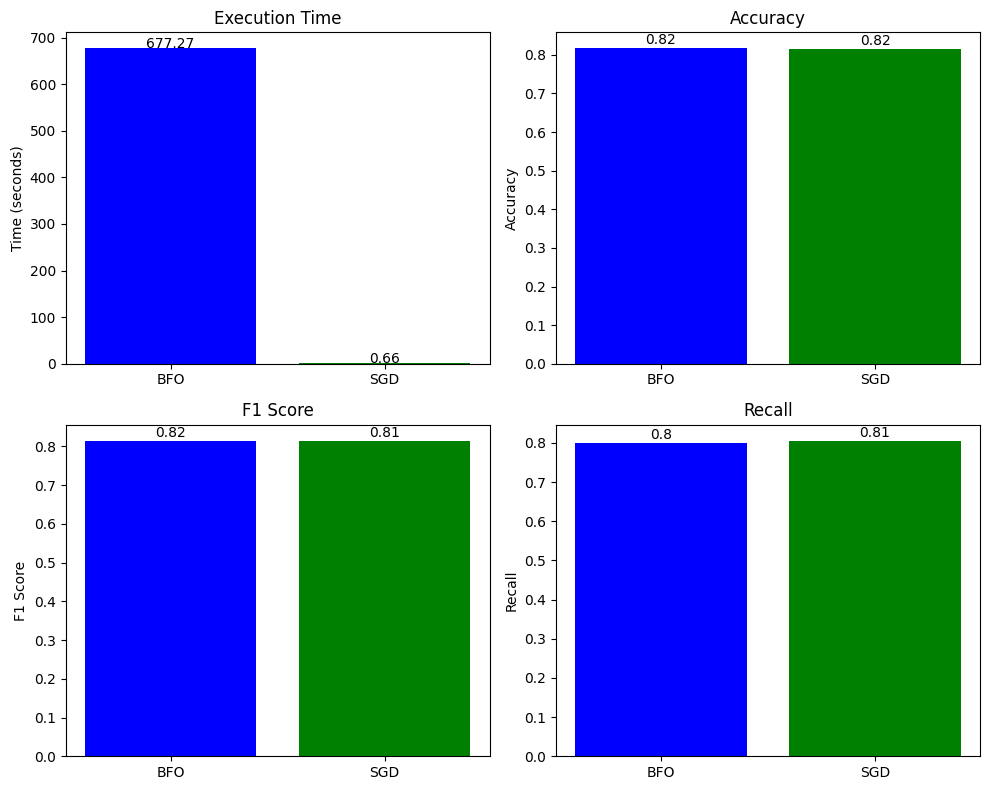

In [21]:

# Data for plotting
execution_times = [execution_time_bfo, execution_time_sgd]
accuracies = [accuracy_bfo, accuracy_sgd]
f1_scores = [f1_score_bfo, f1_score_sgd]
recalls = [recall_bfo, recall_sgd]

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot Execution Time
axs[0, 0].bar(['BFO', 'SGD'], execution_times, color=['blue', 'green'])
axs[0, 0].set_title('Execution Time')
axs[0, 0].set_ylabel('Time (seconds)')
for i, v in enumerate(execution_times):
    axs[0, 0].text(i, v + 0.05, str(round(v, 2)), ha='center')

# Plot Accuracy
axs[0, 1].bar(['BFO', 'SGD'], accuracies, color=['blue', 'green'])
axs[0, 1].set_title('Accuracy')
axs[0, 1].set_ylabel('Accuracy')
for i, v in enumerate(accuracies):
    axs[0, 1].text(i, v + 0.01, str(round(v, 2)), ha='center')

# Plot F1 Score
axs[1, 0].bar(['BFO', 'SGD'], f1_scores, color=['blue', 'green'])
axs[1, 0].set_title('F1 Score')
axs[1, 0].set_ylabel('F1 Score')
for i, v in enumerate(f1_scores):
    axs[1, 0].text(i, v + 0.01, str(round(v, 2)), ha='center')

# Plot Recall
axs[1, 1].bar(['BFO', 'SGD'], recalls, color=['blue', 'green'])
axs[1, 1].set_title('Recall')
axs[1, 1].set_ylabel('Recall')
for i, v in enumerate(recalls):
    axs[1, 1].text(i, v + 0.01, str(round(v, 2)), ha='center')

plt.tight_layout()
plt.show()


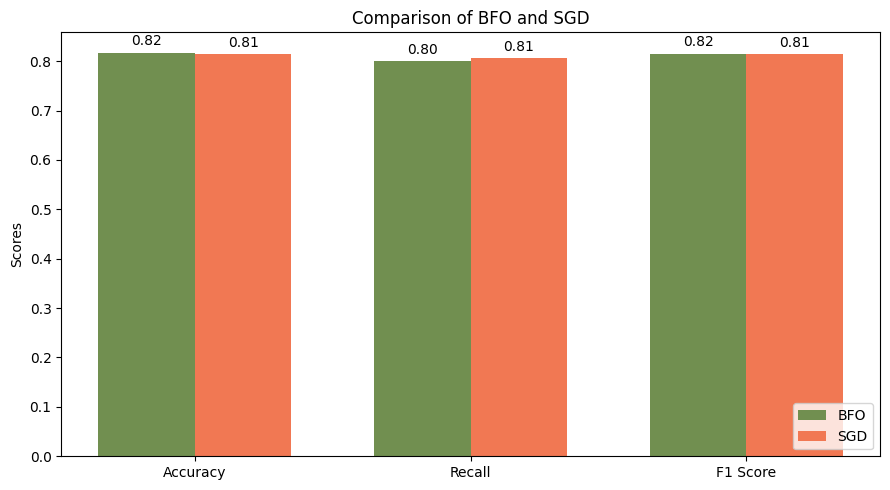

In [56]:

categories = ['Accuracy', 'Recall', 'F1 Score']
bfo_scores = [accuracy_bfo, recall_bfo, f1_score_bfo]
sgd_scores = [accuracy_sgd, recall_sgd, f1_score_sgd]

# Creating the bar plot
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(9, 5))

rects1 = ax.bar(x - width/2, bfo_scores, width, label='BFO', color='#718f50')
rects2 = ax.bar(x + width/2, sgd_scores, width, label='SGD', color='#f17853')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Comparison of BFO and SGD')
ax.set_xticks(x)
ax.set_xticklabels(categories)

ax.legend(loc='lower right')

# Attach a text label above each bar in rects1 and rects2, displaying its height.
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


### Cross validation 

To avoid overfitting and clearly asses the performances of our approaches we will use a stratifies K = 5 folds cross validation on our movie review dataset.

In [32]:

# Evaluate performance of logistic regression with SGD
start_time_sgd = time.time()
sgd_model = LogisticRegression(max_iter=1000)

# Cross-validation with SGD parameters
skf = StratifiedKFold(n_splits=5)
cross_val_scores_sgd = cross_val_score(sgd_model, X_train_vec, y_train, cv=skf, scoring='accuracy')




In [34]:
print(cross_val_scores_sgd)
print(np.mean(cross_val_scores_sgd))

[0.821875 0.85     0.803125 0.84375  0.80625 ]
0.825


In [39]:

# Define objective function for BFO
def objective_function(params):
    C = params[0]
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    return accuracy_score(y_test, y_pred)

# BFO parameters
p = 1  # Number of dimensions (C parameter)
S = 10  # Number of bacteria
Nc = 10  # Number of chemotactic steps
Ns = 5  # Swimming length
Ned = 2  # Number of elimination-dispersal events
Nr = 5  # Number of reproduction steps
ped = 0.1  # Elimination-dispersal probability
LB = [0.1]  # Lower bound for C parameter
UB = [1.0]  # Upper bound for C parameter
C = 0.1  # Step size

class BFO:
    def __init__(self, p, S, Nc, Ns, Ned, Nr, ped, LB, UB, C, OF):
        self.p = p
        self.S = S
        self.Nc = Nc
        self.Ns = Ns
        self.Ned = Ned
        self.Nr = Nr
        self.ped = ped
        self.LB = np.array(LB)
        self.UB = np.array(UB)
        self.C = C
        self.OF = OF

    def run(self):
        # Initialize population of bacteria
        population = self.LB[:, np.newaxis] + (self.UB[:, np.newaxis] - self.LB[:, np.newaxis]) * np.random.rand(self.p, self.S)
        fitness = np.apply_along_axis(self.OF, 0, population)
        best_solution = population[:, np.argmax(fitness)]
        best_fitness = np.max(fitness)

        # Elimination-dispersal loop
        for l in range(self.Ned):
            # Reproduction loop
            for k in range(self.Nr):
                # Chemotactic loop
                for j in range(self.Nc):
                    for i in range(self.S):
                        # Perform a chemotactic step
                        delta = (2 * np.random.rand(self.p) - 1)
                        delta /= np.linalg.norm(delta)
                        new_position = population[:, i] + self.C * delta
                        
                        # Ensure the new position is within bounds
                        new_position = np.clip(new_position, self.LB, self.UB)
                        new_fitness = self.OF(new_position)

                        # Swim
                        for m in range(self.Ns):
                            if new_fitness > fitness[i]:
                                population[:, i] = new_position
                                fitness[i] = new_fitness

                                new_position = population[:, i] + self.C * delta
                                new_position = np.clip(new_position, self.LB, self.UB)
                                new_fitness = self.OF(new_position)
                            else:
                                break

                # Reproduction
                health = np.sum(fitness.reshape(self.S, 1), axis=1)
                sorted_indices = np.argsort(health)
                population = population[:, sorted_indices]
                fitness = fitness[sorted_indices]

                # Split the best bacteria
                for i in range(self.S // 2, self.S):
                    population[:, i] = population[:, i - self.S // 2]
                    fitness[i] = fitness[i - self.S // 2]

            # Elimination-dispersal
            for i in range(self.S):
                if np.random.rand() < self.ped:
                    population[:, i] = self.LB + (self.UB - self.LB) * np.random.rand(self.p)
                    fitness[i] = self.OF(population[:, i])

            # Update best solution
            current_best_fitness = np.max(fitness)
            if current_best_fitness > best_fitness:
                best_fitness = current_best_fitness
                best_solution = population[:, np.argmax(fitness)]

        return best_fitness, best_solution

# Create a BFO instance
bfo = BFO(p, S, Nc, Ns, Ned, Nr, ped, LB, UB, C, objective_function)

# Run BFO
start_time_bfo = time.time()
best_fit_bfo, best_sol_bfo = bfo.run()
end_time_bfo = time.time()
execution_time_bfo = end_time_bfo - start_time_bfo

# Evaluate performance of BFO
model_bfo = LogisticRegression(C=best_sol_bfo[0], max_iter=1000)
model_bfo.fit(X_train_vec, y_train)
y_pred_bfo = model_bfo.predict(X_test_vec)
accuracy_bfo = accuracy_score(y_test, y_pred_bfo)
f1_score_bfo = f1_score(y_test, y_pred_bfo, pos_label='pos')
recall_bfo = recall_score(y_test, y_pred_bfo, pos_label='pos')

# Cross-validation with BFO parameters
skf = StratifiedKFold(n_splits=5)
cross_val_scores_bfo = cross_val_score(model_bfo, X_train_vec, y_train, cv=skf, scoring='accuracy')



In [40]:
# Compare the results
print("Execution time of BFO:", execution_time_bfo)
print("Execution time of SGD:", execution_time_sgd)

print("Accuracy of BFO:", accuracy_bfo)
print("F1 score of BFO:", f1_score_bfo)
print("Recall of BFO:", recall_bfo)
print("Cross-validation scores of BFO:", cross_val_scores_bfo)
print("Mean cross-validation accuracy of BFO:", np.mean(cross_val_scores_bfo))

print("Accuracy of SGD:", accuracy_sgd)
print("F1 score of SGD:", f1_score_sgd)
print("Recall of SGD:", recall_sgd)
print("Cross-validation scores of SGD:", cross_val_scores_sgd)
print("Mean cross-validation accuracy of SGD:", np.mean(cross_val_scores_sgd))

Execution time of BFO: 718.5708272457123
Execution time of SGD: 0.6302294731140137
Accuracy of BFO: 0.8175
F1 score of BFO: 0.8151898734177215
Recall of BFO: 0.8009950248756219
Cross-validation scores of BFO: [0.83125  0.8625   0.80625  0.846875 0.8125  ]
Mean cross-validation accuracy of BFO: 0.8318749999999999
Accuracy of SGD: 0.815
F1 score of SGD: 0.8140703517587939
Recall of SGD: 0.8059701492537313
Cross-validation scores of SGD: [0.821875 0.85     0.803125 0.84375  0.80625 ]
Mean cross-validation accuracy of SGD: 0.825


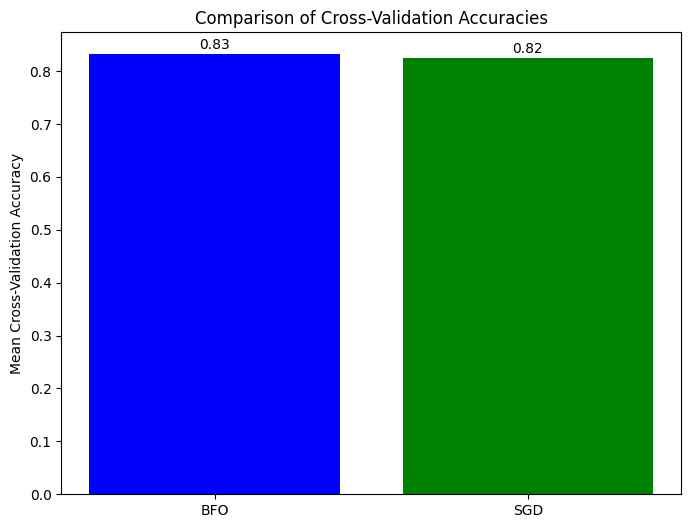

In [42]:
# Plot the comparison of cross-validation scores
cross_val_means = [np.mean(cross_val_scores_bfo), np.mean(cross_val_scores_sgd)]
algorithms = ['BFO', 'SGD']

plt.figure(figsize=(8, 6))
plt.bar(algorithms, cross_val_means, color=['blue', 'green'])
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Comparison of Cross-Validation Accuracies')
for i, v in enumerate(cross_val_means):
    plt.text(i, v + 0.01, str(round(v, 2)), ha='center')
plt.show()

## Discussion

 In conclusion, our study demonstrated that while the Bacterial Foraging Optimization (BFO) algorithm slightly outperformed Stochastic Gradient Descent (SGD) in optimizing the hyperparameters of a logistic regression model for sentiment analysis, it did so at the cost of significantly longer execution time. Both algorithms achieved high accuracy, recall, and F1 scores, but the stark contrast in computational efficiency highlights the practical advantages of SGD for real-time and large-scale applications. This suggests that while BFO can be useful for applications where maximum performance is critical and computational resources are abundant, SGD remains the more efficient choice for most practical scenarios.